In [14]:
from torchvision import models
from PIL import Image
import torchvision
import os
import subprocess
import matplotlib.pyplot as plt
import torch
import requests
import time

plt.style.use('ggplot')

In [15]:
#load FCN ResNet101
fcn = models.segmentation.fcn_resnet101(weights=torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT).eval()

In [21]:
#function to download image
def download_file(url, save_name):

    if not os.path.exists(save_name):
        subprocess.run(['curl', '-L', url, '-o', save_name, '-s'])

In [22]:
#directory for inference data
inference_dir = 'semantic_seg_inference_data'
os.makedirs(inference_dir, exist_ok=True)

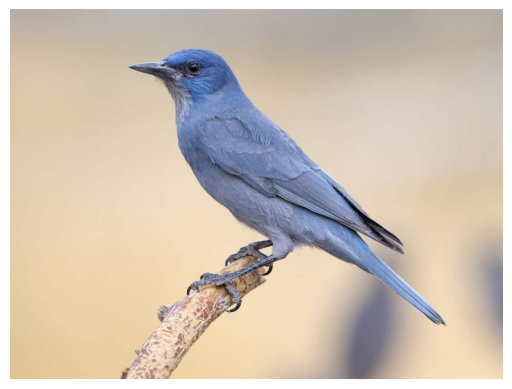

In [32]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/bird.jpg',
    save_name=os.path.join(inference_dir, 'bird.jpg')
)
img = Image.open(os.path.join(inference_dir, 'bird.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()



In [33]:
#apply preprocessing
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [34]:
#take the 'out' key
out = fcn(inp)['out']
print(out.shape)

torch.Size([1, 21, 224, 224])


In [35]:
#take max index for every pixel position
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

(224, 224)
[0 3]


In [40]:
#convert 2d image to rgb image wher each label is mapped to its corresponding color
def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

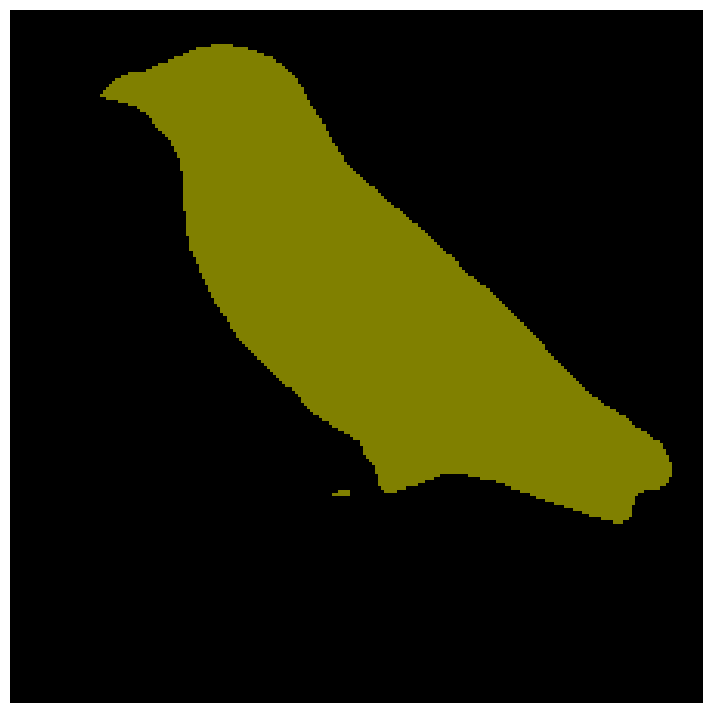

In [41]:
rgb = decode_segmap(om)
plt.figure(figsize=(12, 9))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [49]:
#move all under one function
def segment(net, path, show_orig=True, dev='cuda'):

    plt.figure(figsize=(10, 7))
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    trf = T.Compose([T.Resize(640),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

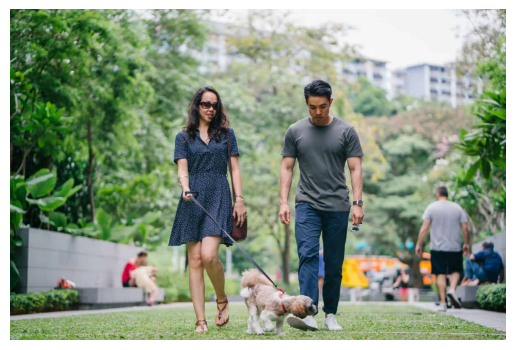

<Figure size 1000x700 with 0 Axes>

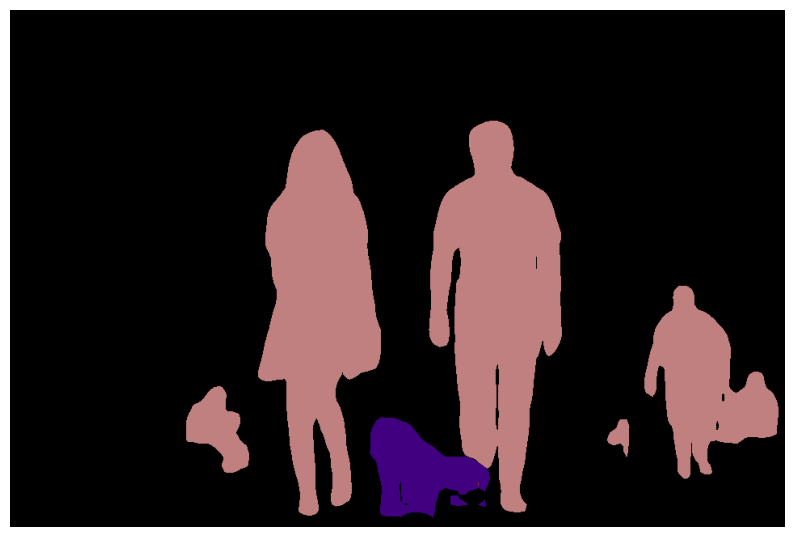

In [50]:
#test on more complex image
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg',
    save_name=os.path.join(inference_dir, 'person.jpg')
)
img = Image.open(os.path.join(inference_dir, 'person.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

segment(fcn, path=os.path.join(inference_dir, 'person.jpg'), show_orig=False)
